In [54]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [55]:
# Load and pre-process data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [56]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
])

In [57]:
# Model setup
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

# Block 1
x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 2
x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Block 3
x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

# Classifier
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = Model(inputs, outputs)

In [58]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", min_delta=0.001)

In [59]:
# Training the model
history = model.fit(
    train_images, train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=128,
    callbacks=[lr_scheduler, early_stop],
    verbose=1
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3010 - loss: 2.3916 - val_accuracy: 0.1656 - val_loss: 3.5322 - learning_rate: 5.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4552 - loss: 1.5951 - val_accuracy: 0.4810 - val_loss: 1.5678 - learning_rate: 5.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5136 - loss: 1.3775 - val_accuracy: 0.5007 - val_loss: 1.5179 - learning_rate: 5.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5550 - loss: 1.2702 - val_accuracy: 0.5875 - val_loss: 1.2212 - learning_rate: 5.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5783 - loss: 1.1863 - val_accuracy: 0.6346 - val_loss: 1.0562 - learning_rate: 5.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6052 - loss: 1.1202 - val_accuracy: 0.5469 - val_loss: 1.5659 - learning_rate: 5.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/ste

In [60]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7964


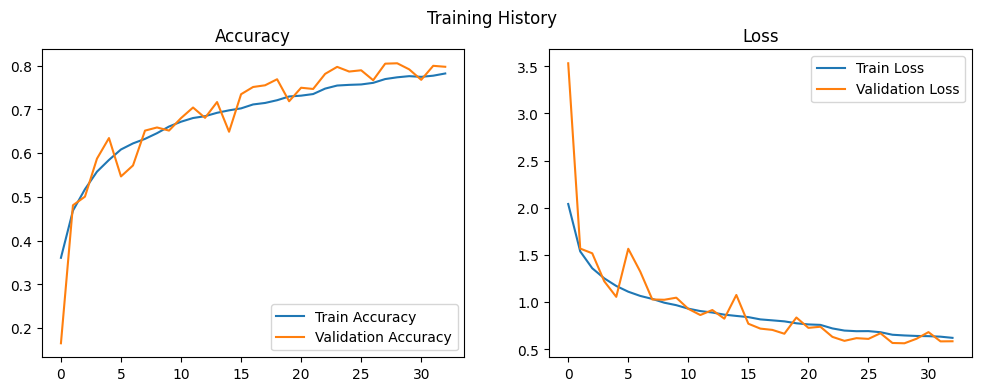

In [61]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history, "Training History")

In [62]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt



In [63]:
# Load and pre-process data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess input for ResNet50
x_train = tf.keras.applications.resnet50.preprocess_input(x_train)
x_test = tf.keras.applications.resnet50.preprocess_input(x_test)

# Convert labels to categorical
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print("Train data shape:", x_train.shape)
print("Test data shape:", x_test.shape)


Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [64]:
# Load the ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Freeze all layers except the last few
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Create the model
model = Sequential([
    layers.Lambda(lambda image: tf.image.resize(image, (224, 224))),
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(10, activation="softmax"),
])

In [65]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.00002), loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks
lr_schedule = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=1, min_lr=1e-6, verbose=1
)

es = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=2, restore_best_weights=True
)


In [ ]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    callbacks=[es, lr_schedule],
    validation_split=0.2,
    verbose=1,
)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 213s 129ms/step - accuracy: 0.2604 - loss: 2.2175 - val_accuracy: 0.8403 - val_loss: 0.8311 - learning_rate: 2.0000e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 192s 126ms/step - accuracy: 0.5231 - loss: 1.4265 - val_accuracy: 0.8843 - val_loss: 0.6132 - learning_rate: 2.0000e-05
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.6435 - loss: 1.1302 - val_accuracy: 0.9018 - val_loss: 0.4866 - learning_rate: 2.0000e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 126ms/step - accuracy: 0.7255 - loss: 0.9376 - val_accuracy: 0.9111 - val_loss: 0.4059 - learning_rate: 2.0000e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7767 - loss: 0.8042

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")



In [ ]:
# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history(history, "ResNet50")
